# Learning FLPO

In this code, we will implement the hierarchical ML architecture to predict the parameters in the FLPO setup.

In [11]:
import torch
from VRP_Net import VRPNet
from matplotlib import pyplot as plt
from utils import *
import os
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np

# Loading the Data

In [12]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Running on: " , device)
num_data = 10 # number of FLPO instances
num_nodes = 30
city_dim = 2
data = torch.rand(num_data,num_nodes,city_dim).to(device)


Running on:  cpu


# Loading the VRP NET Module

In [13]:
hidden_dim = 128
num_layers = 3
num_heads = 8
input_dim = 2
num_samples = 1 # for inference
vrpnet = VRPNet(input_dim,hidden_dim,device,num_heads=num_heads,num_enc_layers=num_layers,num_dec_layers=num_layers,use_PE=False)
vrpnet.load_state_dict(torch.load('Saved models/POMO2025_03_12 11_03_550.8357473611831665best_model.pth', map_location=torch.device('cpu')))#,weights_only=False))
vrpnet.eval()
print('VRP NET loaded.')
print(summary(vrpnet))

VRP NET loaded.
Layer (type:depth-idx)                                                 Param #
VRPNet                                                                 --
├─Encoder: 1-1                                                         --
│    └─Linear: 2-1                                                     384
│    └─PositionalEncoding: 2-2                                         --
│    └─TransformerEncoder: 2-3                                         --
│    │    └─ModuleList: 3-1                                            594,816
├─Decoder: 1-2                                                         --
│    └─TransformerDecoder: 2-4                                         --
│    │    └─ModuleList: 3-2                                            793,728
├─PositionalEncoding: 1-3                                              --
Total params: 1,388,928
Trainable params: 1,388,928
Non-trainable params: 0


# Generating d_min

In [14]:
all_samples = torch.zeros(num_data, num_nodes, num_samples).to(device)
for i in range(num_samples):
    _, actions = vrpnet(data, mod='train')
    all_samples[:,:,i:i+1] = actions
opt_sample_indices = []


In [15]:
d_mins = np.zeros(num_data)
for data_idx in range(num_data):
    costs_for_data = [route_cost(data[data_idx:data_idx+1], all_samples[data_idx:data_idx+1, :, sample_idx]) for sample_idx in range(num_samples)]
    costs_tensor = torch.tensor(costs_for_data)
    d_min, opt_sample_index = torch.min(costs_tensor, dim=0)  
    opt_sample_indices.append(opt_sample_index.item())
    d_mins[data_idx] = d_min
opt_sample_indices = torch.tensor(opt_sample_indices)
actions = all_samples[torch.arange(num_data),:,opt_sample_indices]
print("d_mins for all data are: ",d_mins)

d_mins for all data are:  [1.70865619 0.61032188 0.20331575 0.09000816 0.22877039 0.9916532
 0.72838849 0.11450128 0.4081955  1.11983597]


# Loading Free Energy Network

Dhananjay's code for loading his DNN is here. The output of this block should be Y.

In [57]:
import LSE_net
lse_data = torch.load('LSE_models/lse_2543_1624.pth')
n_inputs = lse_data['n_inputs']
n_outputs = lse_data['n_outputs']
layers = lse_data['layers']
weights = lse_data['model_state_dict']
lse_net = LSE_net.dnn(n_inputs, n_outputs, layers)
lse_net.load_state_dict(weights)
lse_net.eval()
print(f'n_inputs:{n_inputs}\tn_outputs:{n_outputs}\tlayers:{layers}\nlse_net:\n{lse_net}')

n_inputs:3	n_outputs:1	layers:[20, 10]
lse_net:
dnn(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)


# Calculating Free Energy

Feeding the d_min from Salar Block to get the Free energy

In [58]:
b_arr = lse_data['b_arr']
len_Darray = lse_data['len_Darray']
io_scale = lse_data['io_scale']
b_min = b_arr[0]
b_max = b_arr[-1]
d_min_random = np.random.choice(d_mins, 1)[0]
# d_min_random = d_mins[0]
st = 0
In = torch.tensor([[-io_scale/b_min*np.log(len_Darray), io_scale*d_min_random, b] for b in b_arr], dtype=torch.float32)
print(In)
Out = lse_net(In)
print(Out)
# Out.backward()
# print(In.grad)

tensor([[-5.2983e+00,  1.7087e-02,  1.0000e-02],
        [-5.2983e+00,  1.7087e-02,  1.0500e-02],
        [-5.2983e+00,  1.7087e-02,  1.1025e-02],
        [-5.2983e+00,  1.7087e-02,  1.1576e-02],
        [-5.2983e+00,  1.7087e-02,  1.2155e-02],
        [-5.2983e+00,  1.7087e-02,  1.2763e-02],
        [-5.2983e+00,  1.7087e-02,  1.3401e-02],
        [-5.2983e+00,  1.7087e-02,  1.4071e-02],
        [-5.2983e+00,  1.7087e-02,  1.4775e-02],
        [-5.2983e+00,  1.7087e-02,  1.5513e-02],
        [-5.2983e+00,  1.7087e-02,  1.6289e-02],
        [-5.2983e+00,  1.7087e-02,  1.7103e-02],
        [-5.2983e+00,  1.7087e-02,  1.7959e-02],
        [-5.2983e+00,  1.7087e-02,  1.8856e-02],
        [-5.2983e+00,  1.7087e-02,  1.9799e-02],
        [-5.2983e+00,  1.7087e-02,  2.0789e-02],
        [-5.2983e+00,  1.7087e-02,  2.1829e-02],
        [-5.2983e+00,  1.7087e-02,  2.2920e-02],
        [-5.2983e+00,  1.7087e-02,  2.4066e-02],
        [-5.2983e+00,  1.7087e-02,  2.5270e-02],
        [-5.2983e+00

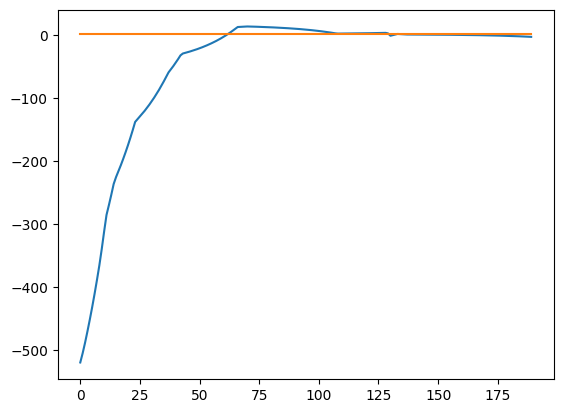

In [59]:
Out_numpy = Out.view(-1).detach().numpy()/io_scale
plt.plot(Out_numpy)
plt.plot(d_min_random*np.ones(Out_numpy.shape))
plt.show()

# Calculating the gradients

The output of this block shoud be dF/dy

First calculate $\frac{\partial F}{\partial d_{min}}$ (code in progress)

In [63]:
# fix beta
b = np.random.choice(b_arr)
d_mins_torch = torch.tensor(d_mins, dtype=torch.float32, requires_grad=True).view(-1,1)
const_bmin = -io_scale/b_arr[0] * np.log(len_Darray) * torch.ones(len(d_mins), dtype=torch.float32).view(-1,1)
const_b = b * torch.ones(len(d_mins), dtype=torch.float32).view(-1,1)
In = torch.concatenate((const_bmin, d_mins_torch, const_b), axis=1)
Out = lse_net(In)
# print(Out)
Out[0].retain_grad()
Out[0].backward()
d_mins_torch.grad

/var/folders/sh/ndxykdmj1q9cwr2kpvkvcbs80000gn/T/ipykernel_89473/1274708057.py:11: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  d_mins_torch.grad


# Running CLF to determin Y

The GD code here

# Closing the Beta Loop for Annealing